In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.display import display
import sys
import os
import logging
sys.path.insert(0,'../src')
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 100

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.cm as cm
from scipy.stats import spearmanr

In [18]:
# compare the method result
from io_utils import load_data_from_file
regime = 2
ddir = '/share/PI/sabatti/feat_viz/corr_sim/'

for regime in range(3):
    data_name = 'regime_{}'.format(regime)
    data_fn = os.path.join(ddir, data_name, 'data_dict.pkl')
    data_dict = load_data_from_file(data_fn, 'pkl') 
    true_lam = data_dict['lam']
    print('Regime: {}'.format(regime))
    for method in ['ours', 'palantir', 'paga']:
        if method == 'ours':
            fn = os.path.join(ddir, data_name, 'method_result.pkl')
            result = load_data_from_file(fn, 'pkl')
            for name in ['lam_init', 'lam_update']:
                lam = result[name]
                corr = abs(spearmanr(lam, true_lam).correlation)
                print('{} ({}): {:.4f}'.format(method, name,corr))
        else:
            fn = 'ti_{}_result.csv'.format(method)
            fn = os.path.join(ddir, data_name, fn)
            out_df = pd.read_csv(fn, index_col=0)
            corr = abs(spearmanr(out_df['pseudotime'], true_lam).correlation)
            print('{}: {:.4f}'.format(method, corr))

Regime: 0
ours (lam_init): 0.8033
ours (lam_update): 0.9985
palantir: 0.9961
paga: 0.9901
Regime: 1
ours (lam_init): 0.7946
ours (lam_update): 0.9977
palantir: 0.9936
paga: 0.9771
Regime: 2
ours (lam_init): 0.8059
ours (lam_update): 0.9950
palantir: 0.8314
paga: 0.6568


{'model': 'normal', 'block_size': 150, 'corr_value': 0.01, 'scale': 0.5, 'seed': 10}
{'FDP': 0.026200873362445413, 'Power': 0.5331739390316796, 'Corr': 0.9984615175384524, 'Num_Nonnulls': 1673, 'Num_Rejections': 916}
all_coeffient
Counter({-1: 5094, 0: 150, 1: 150, 2: 150, 3: 150, 4: 150, 5: 150})


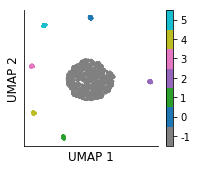

all_expression
Counter({-1: 5094, 0: 150, 1: 150, 2: 150, 3: 150, 4: 150, 5: 150})


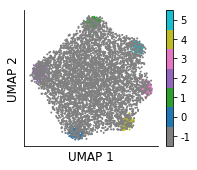

rejected_coeffient
Counter({0: 150, 1: 150, 2: 150, 3: 150, 4: 145, 5: 144, -1: 27})


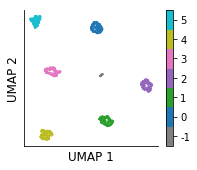

rejected_expression
Counter({0: 150, 1: 150, 2: 150, 3: 150, 4: 145, 5: 144, -1: 27})


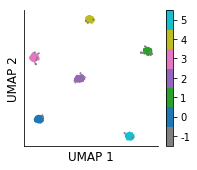

In [43]:
from sim_utils import get_corr_sim, generate_invariant_data, model_corr_noise
from plot_utils import plot_ground_truth_heatmap
from plot_utils import get_sim_color_map, plot_col_color_heatmap
from main_methods import run_procedure
from sim_utils import selction_eval
from spline_utils import setup_basis, spline_fit
from general_utils import rank_and_bin
import umap
from plot_utils import plot_scatter_discrete
from collections import Counter
from io_utils import load_data_from_file

logger = logging.getLogger("feat_viz")
logging.basicConfig(format='[%(name)s %(levelname)s] %(message)s', level=logging.INFO)

def compute_embedding(mtx, sel_idx=None):
    uobj = umap.UMAP(random_state=10101)
    if sel_idx is None:
        sel_idx = np.arange(mtx.shape[0])
    print("input dimension: {}".format(mtx[sel_idx, :].shape))
    embedding = uobj.fit_transform(mtx[sel_idx, :])
    df = pd.DataFrame(embedding, columns=["umap 1", "umap 2"])
    df["id"] = sel_idx
    return df

def compute_all_embeddings(result, c_mtx, x):
    embed_dict = {}
    sel_list = ["all", "rejected"]
    mat_list = ["coeffient", "expression"]
    for sel in sel_list:
        if sel == "rejected":
            sel_idx = result["rejections"]
        else:
            sel_idx = None
        for mat in mat_list:
            if mat == "coeffient":
                in_mtx = c_mtx
            else:
                in_mtx = x.T
            key = "{}_{}".format(sel, mat)
            print("Computing embedding for: {}".format(key))
            df = compute_embedding(in_mtx, sel_idx=sel_idx)
            embed_dict[key] = df
    return embed_dict

def plot_embeddings(embed_dict, var_df):
    
    fontsize = 12
    sel_list = ["all", "rejected"]
    mat_list = ["coeffient", "expression"]
    
    for i, sel in enumerate(sel_list):
        for j, mat in enumerate(mat_list):
            name = "{}_{}".format(sel, mat)
            print(name)
            fig, ax = plt.subplots(1, 1, figsize=(3, 2.5))
            plt_df = embed_dict[name]
#             ax = axes[j, i]
            var_labs = var_df.loc[plt_df["id"]]['nn_grp'].values
            lut = get_sim_color_map(np.unique(var_labs))
            print("{}".format(Counter(var_labs)))
            plot_scatter_discrete(plt_df[["umap 1", "umap 2"]].values, var_labs, ax=ax, ms=1, cols=lut)
            ax.set_xticks([]) 
            ax.set_yticks([]) 
            ax.set_xlabel("UMAP 1", fontsize=fontsize)
            ax.set_ylabel("UMAP 2", fontsize=fontsize)

#             if j == 0:
#                 ax.set_title("using {} genes\n".format(sel), fontsize=fontsize)
#             if i == 0:
#                 ax.set_ylabel("using {} \nmatrix input\n\nUMAP 2".format(mat), fontsize=fontsize)
#             else:
#                 ax.set_ylabel("UMAP 2".format(mat), fontsize=fontsize)
            plt.show()
    # plt.savefig("/scratch/users/jjzhu/tmp_fig/spline_genes.pdf")
#     plt.show()

from plot_utils import plot_by_noise_struct
# def run_pipeline(regime):
regime = 0
sim_params = get_corr_sim(regime=regime)
print(sim_params['null_struct'])
ddir = sim_params['sim_dir']
os.makedirs(ddir, exist_ok=True)
fns = {
    'data_dict': os.path.join(ddir, 'data_dict.pkl'),
    'var_df': os.path.join(ddir, 'var_df.csv'),
    'result': os.path.join(ddir, 'method_result.pkl'),
    'coeff_mtx': os.path.join(ddir, 'coeff_matrix.npy'),
    'embed_dict': os.path.join(ddir, 'embed_dict.pkl'),
}
var_df = load_data_from_file(fns['var_df'], 'csv')
embed_dict = load_data_from_file(fns['embed_dict'], 'pkl')
data_dict = load_data_from_file(fns['data_dict'], 'pkl') # {'z': z, 'x': x, 'lam': lam_true}
x = data_dict['x']
z = data_dict['z']
lam_true = data_dict['lam']
result = load_data_from_file(fns['result'], 'pkl')
selction_eval(result, lam_true, sim_params, var_df)
c_mtx = load_data_from_file(fns['coeff_mtx'], 'npy')
plot_embeddings(embed_dict, var_df)

In [10]:
result.keys()

dict_keys(['lam_init', 'lam_update', 'p_vals', 'rejections'])

In [14]:
from patsy import dmatrix
def refit_curves(coeff_mtx, base_args, x):
    x = np.linspace(min(x), max(x), 50)
    exog = dmatrix(base_args, {"x": x}, return_type='dataframe')
    y = np.matmul(exog.values, coeff_mtx.T)
    logger.info("Fitted points stored in {}".format(y.shape))
    return x, y

lam = result["lam_update"]
base_args = setup_basis(lam)
np.random.seed(10)
coeff = c_mtx+ 0.1*np.random.normal(size=c_mtx.shape)
x_vals, fit_mtx = refit_curves(coeff, base_args, lam)

[feat_viz INFO] Fitted points stored in (50, 5994)


In [15]:
var_df.head()

,var_id,nn_grp,corr_grp,lm_corr
0,0,0,12,False
1,1,0,19,True
2,2,0,25,False
3,3,0,0,False
4,4,0,16,False


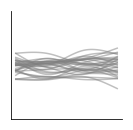

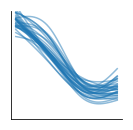

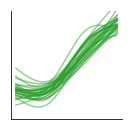

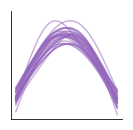

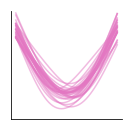

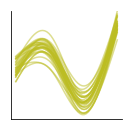

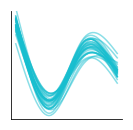

In [41]:
def plot_multi_curves(ax, x, y_mtx, **kwargs):
    assert len(x) == y_mtx.shape[0], "dimension mismatch"
    for i in range(y_mtx.shape[1]):
        ax.plot(x, y_mtx[:,i], **kwargs)

# for grp in range(1+max(np.unique(var_df.nn_grp))):
for grp in np.unique(var_df.nn_grp):
    ids = var_df.loc[var_df['nn_grp']==grp]['var_id']
    fig, ax = plt.subplots(1, 1, figsize=(2,2))
    # sub_sample:
    np.random.seed(10)
    ids = np.random.choice(ids, size=30)
    plot_multi_curves(ax, x_vals, fit_mtx[:, ids],
                      alpha=0.5, color=lut[grp])
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.set_xticks([], [])
    ax.set_yticks([], [])
    ax.set_ylim(-1.1,1.1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.show()

In [ ]:
from plot_utils import get_sim_color_map, plot_col_color_heatmap
from sklearn.metrics import pairwise_distances

def get_top_grps(df, num_grps):
    df = df.sort_values('corr_grp') 
    grp_df = df[['corr_grp','var_id']].groupby('corr_grp').size()
    grp_df = grp_df.sort_values(ascending=False)
    use_grp_ids = list(grp_df.index)
    if num_grps:
        use_grp_ids = use_grp_ids[:num_grps]
    df = df.loc[df['corr_grp'].isin(use_grp_ids)]   
    return df

def col_selector(var_df, sel=[], num_grps=None):
    if len(sel) > 0:
        var_df = var_df.loc[sel]
    print(var_df.shape)
    # non-null features
    df_1 = var_df.loc[var_df['nn_grp'] >= 0]
    order = [2, 0, 5, 3, 4, 1]
    df_1_ord = pd.DataFrame()
    for grp in order:
        gdf = df_1.loc[df_1['nn_grp']==grp]
        df_1_ord = pd.concat([df_1_ord, gdf])
    df_1 = df_1_ord
    # null features correlated to the lm genes
    df_2 = var_df.loc[var_df['nn_grp'] == -1]
    df_2 = df_2.loc[df_2['lm_corr']]
    df_2 = get_top_grps(df_2, num_grps)
    # null features uncorrelated with the lm genes
    df_3 = var_df.loc[var_df['nn_grp'] == -1]
    df_3 = df_3.loc[-df_3['lm_corr']]
    df_3 = get_top_grps(df_3, num_grps)
    # combine everything
    if num_grps:
        df = pd.concat([df_1, df_2])
    else:
        df = pd.concat([df_1, df_2, df_3])
    print(df.shape)
    return df

def plot_distance(in_mtx, df, lut, val_min=None, val_max=None):
    in_mtx = in_mtx[:, df['var_id']]
    grp_ids = df['nn_grp']
#     lut = get_sim_color_map(grp_ids)
#     dist_feat = pd.DataFrame(in_mtx).corr(method='spearman')
#     dist_feat = np.exp(-pairwise_distances(in_mtx.T, metric="euclidean")**2)
    dist_feat = pairwise_distances(in_mtx.T, metric="euclidean")
    plot_col_color_heatmap(dist_feat, grp_ids, lut, square=True, 
                           val_min=val_min, val_max=val_max)
    
def plot_data_mtx(in_mtx, df, lut, val_min=None, val_max=None, lam=[], short=False):
    in_mtx = in_mtx[:, df['var_id']]
    if len(lam) > 0:
        sort_idx = np.argsort(lam)
        in_mtx = in_mtx[sort_idx, :]
    grp_ids = df['nn_grp']
    lut = get_sim_color_map(grp_ids)
    plot_col_color_heatmap(in_mtx, grp_ids, lut, 
                           val_min=val_min, val_max=val_max, short=short)

# plot_ground_truth_heatmap(lam_true, x[:, ])
lut = get_sim_color_map(np.unique(var_df['nn_grp']))
df_sel = col_selector(var_df, sel=result['rejections'])
plot_ground_truth_heatmap(lam_true, x[:, df_sel['var_id']])

(1701, 4)
(1535, 4)


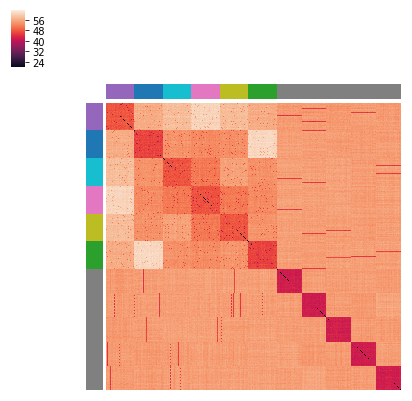

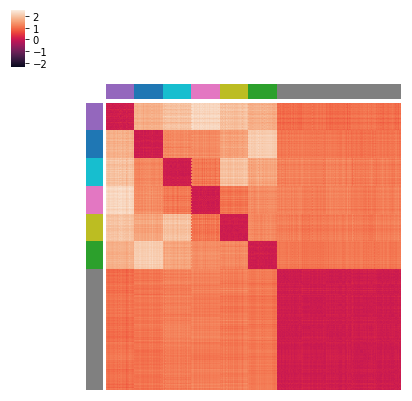

In [26]:
# plot_ground_truth_heatmap(lam_true, c_mtx.T[:, df_sel['var_id']])
heat_sel = col_selector(var_df, sel=result['rejections'], num_grps=5)
plot_distance(x, heat_sel, lut, val_min=20)
plot_distance(c_mtx.T, heat_sel, lut, val_min=-2.4)

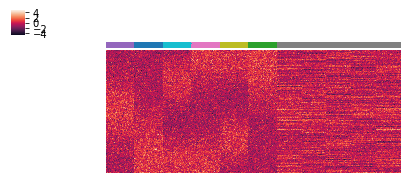

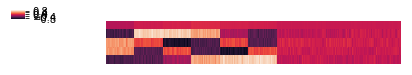

In [28]:
plot_data_mtx(x, heat_sel, lut, lam=lam_true)
plot_data_mtx(c_mtx.T, heat_sel, lut, short=True)

In [24]:
heat_sel.head()

,var_id,nn_grp,corr_grp,lm_corr
300,300,2,34,False
301,301,2,27,False
302,302,2,6,False
303,303,2,23,False
304,304,2,26,False


In [ ]:
plot_distance(x, df, lut)

In [ ]:
plot_distance(c_mtx.T, df, lut)

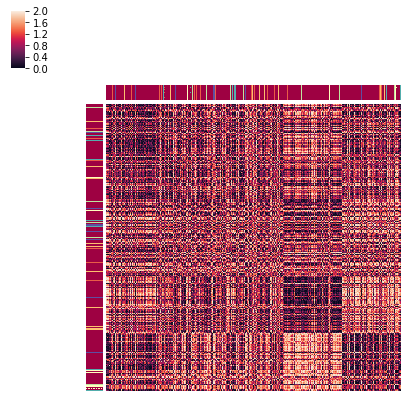

In [47]:
plot_by_noise_struct(var_df, lam_true, c_mtx.T, order_by_noise=True)

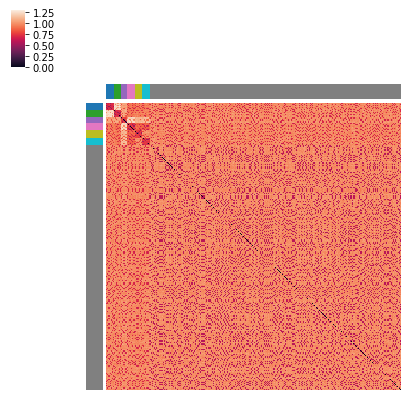

In [57]:
plot_by_noise_struct(var_df, lam_true, x, order_by_noise=False)

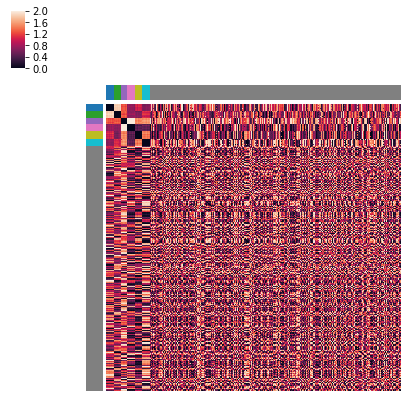

In [58]:
plot_by_noise_struct(var_df, lam_true, c_mtx.T, order_by_noise=False)

{'model': 'normal', 'block_size': 150, 'corr_value': 0.2, 'scale': 0.5, 'seed': 10}
{'FDP': 0.024074074074074074, 'Power': 0.630005977286312, 'Corr': 0.9976637678505634, 'Num_Nonnulls': 1673, 'Num_Rejections': 1080}
Counter({-1: 5094, 0: 150, 1: 150, 2: 150, 3: 150, 4: 150, 5: 150})
Counter({-1: 5094, 0: 150, 1: 150, 2: 150, 3: 150, 4: 150, 5: 150})
Counter({-1: 209, 0: 150, 1: 150, 2: 150, 3: 150, 5: 139, 4: 132})
Counter({-1: 209, 0: 150, 1: 150, 2: 150, 3: 150, 5: 139, 4: 132})


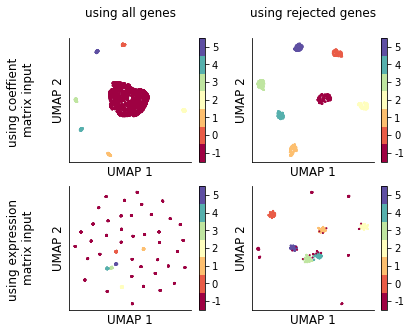

In [10]:
run_pipeline(1)

In [13]:
run_pipeline(0)

NameError: name 'run_pipeline' is not defined